<span style="font-size:32px; color:yellow">Generation of Utterances</span>

In [24]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model="llama3:70b", 
                        base_url="http://localhost:11434/v1", 
                        temperature=0.7,
                        api_key="NA")


def diversify_uttr(uttr : str):
  
    #model = ChatGroq(temperature=0.9, model="llama3-70b-8192")
        
    PROMPT = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
                You are a prompt diversifier with poor language skills.

                You will be given a random user prompt about some request.
                The user's prompt is originally directed to a car's voice assistant to execute. 

                Your task is to come up with a very similar prompt by modifying the given user prompt. 
                Simply rephrase the given user prompt into a short and very precise sentence with the exact same meaning. 
                
                You can rephrase it into a question or an instruction.
                
                You MUST borrow most of the verbatim from the given user prompt.

                DO NOT generate a duplicate prompt for very similar user prompts. Instead, jumble the sequence of words. 
                
                You ONLY return the modified prompt in a list format. DO NOT return anything other than the list.
        
                Example:
                    Input:
                        what's the weather like

                    Output: 
                        [tell me how the weather is like]

                
                If the input prompt is in a different language(German, Spanish or something else), generate a similar prompt in the same language by borrowing verbatim. 
                Avoid duplicate output generations, instead jumble the input sequence of words.

                Example 1:
                    Input:
                        wie wird das Wetter

                    Output: 
                        [wie sieht das Wetter aus]

                Example 2:
                    Input:
                        wie ist das Wetter heute
                    Output:
                        Sag mir, wie das Wetter heute ist


                """,
            ),
            ("user", "Input prompt:\n {utterance}\n--End of current chunks--"),
        ]
        )

    runnable = PROMPT | llm

    new_prompt = runnable.invoke({
        "utterance": uttr
    }).content

    '''#Pydantic data class
    class Sentence(BaseModel):
        """Extracting the creative prompt."""
        prompt: str
        
    # Extraction to catch-all LLM responses. This is a bandaid
    extraction_chain = llm.with_structured_output(Sentence)
    extracted_prompt = extraction_chain.invoke(new_prompt)
    '''
    return new_prompt

def prompt_extractor(generated_prompt):

        PROMPT = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    """
                    You are a prompt extractor.
                    You only extract the generated prompt string from the given input.
                    The target string for extraction is usually within [] in a list format. 
                    
                    Only return the extracted prompt WITHOUT any braces. DO NOT RETURN ANYTHING ELSE.
                    """,
                ),
                ("user", "Retrieve only the prompt from the following text:\n{generated_p}"),
            ]
        )

        runnable = PROMPT | llm

        extracted_prompt = runnable.invoke({
            "generated_p": generated_prompt
        }).content

        return extracted_prompt

#diversify_uttr("to home")

In [ ]:
import csv 
import datetime
import pandas as pd

pathname = '/home/devbox/test/Diversifying_uttr/data/Inq_weather/'
filename = 'Inq_Weather.csv'
type = '.csv'
#in_file = open(pathname + filename, "r")
out_file = str(pathname + "LLM_utt-" + str(datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")) + type)


df = pd.read_csv(pathname + filename)
user_utt_col = df['utterance']
user_utter = ['']
llm_utt_col = ['']


number_rows = int(input("Number of rows: "))
for row_idx, user_utt in enumerate(user_utt_col):
    if (row_idx == 0): # Doesn't modify the 2nd row
        continue
    if (row_idx>number_rows+1):
        break
    
    new_uttr = diversify_uttr(user_utt)
    extracted_uttr = prompt_extractor(new_uttr)
    user_utter.append(user_utt)
    llm_utt_col.append(extracted_uttr)
    print(f"********************+** Utterance {row_idx} ***************************")
    print(f"\nUser: {user_utt}")
    print(f"\nLLM: {extracted_uttr}")

    # Writes into csv    
ds = pd.DataFrame({'User_utterance' : user_utter,
                   'LLM_utterance' : llm_utt_col
                   })  
ds.to_csv(out_file, index=False)
        

'''for row_index, row in enumerate(reader):
    if (row_index == 0) or (row_index==1): # Doesn't modify the header
        writer.writerow(row)
        continue
    if (row_index > number_rows):
        break
    new_uttr = diversify_uttr(row[0])
    extracted_uttr = prompt_extractor(new_uttr)
    print(f"********************+** Utterance {row_index-1} ***************************")
    print(f"\nUser: {row[0]}")
    print(f"\nLLM: {extracted_uttr}")

    row.append(extracted_uttr)
    writer.writerow(row)'''
    
'''in_file.close()
out_file.close()'''

In [28]:
print(user_utt_col[:10])

0                              NaN
1                          weather
2               What's the weather
3         What's the weather today
4                          Weather
5    What's the weather like today
6      What's the weather tomorrow
7          What's the weather like
8        What is the weather today
9      What's the weather forecast
Name: utterance, dtype: object


<span style="font-size:32px; color:yellow">Cosine Similarity of embedded Utterances</span>

In [2]:

from langchain_community.embeddings import HuggingFaceBgeEmbeddings

small_model_name = "BAAI/bge-small-en"  #emb_dimension = 384
model_name = "BAAI/bge-large-en-v1.5"   #emb_dimension = 1024
model_kwargs = {"device": "cuda"}
encode_kwargs = {"normalize_embeddings": True}
hf = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)
hf_small = HuggingFaceBgeEmbeddings(
    model_name=small_model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)


/home/devbox/miniconda3/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


<span style="font-size:28px; color:yellow">3D plot of LLM Utterances</span>

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
import pandas as pd

def embedding(utterance : str):
    embedding = hf_small.embed_query(utterance)
    return embedding

pathname = '/home/devbox/test/Diversifying_uttr/data/Seat_massage/'
filename = 'LLM_utt.csv'
in_file = (pathname + filename)
df = pd.read_csv(in_file)
llm_utt_col = df['User_utterance'].to_list()
number_rows = int(input("Number of PCA samples: ")) 

pca_array = []
start_idx = 29
for m, llm in enumerate(llm_utt_col[start_idx-2:start_idx+number_rows]):
    pca_array.append(list(embedding(llm)))
print(f"Original dimension {np.shape(pca_array)}")

std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(pca_array)

pca = PCA(n_components=3)
vectors = pca.fit_transform(scaled_df)

print(f'Transformed dimension: {vectors.shape}')
#tsne = TSNE(n_components=3, perplexity=2)
#tsne_result = tsne.fit_transform(scaled_df)
#print(f'TSNE result shape: {tsne_result.shape}')

fig = px.scatter_3d(vectors[:300],x=0,y=1,z=2, color=llm_utt_col[start_idx-2:start_idx+number_rows])
#fig.update_layout(scene_camera_up=dict(x=0, y=0, z=1), scene_camera_eye=dict(x=0, y=-1, z=0))
fig.show()


Original dimension (40, 384)
Transformed dimension: (40, 3)


In [46]:
ar = [3, 2, 7, 8, 9, 0]

for m, llm in enumerate(ar[1:3]):
    print(llm)

print(type(llm_utt_col.to_list()))

2
7
<class 'list'>


<span style="font-size:28px; color:yellow">Animate Rotation</span>

In [67]:
'''import plotly.graph_objects as go
import numpy as np

# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = np.cos(t), np.sin(t), t
'''
fig= go.Figure(fig)

x_eye = -1.25
y_eye = 2
z_eye = 0.5

fig.update_layout(
         title='Animation Test',
         width=980,
         height=700,
         scene_camera_eye=dict(x=x_eye, y=y_eye, z=z_eye),
         updatemenus=[dict(type='buttons',
                  showactive=False,
                  y=1,
                  x=0.8,
                  xanchor='left',
                  yanchor='bottom',
                  pad=dict(t=45, r=10),
                  buttons=[dict(label='Play',
                                 method='animate',
                                 args=[None, dict(frame=dict(duration=100, redraw=True), 
                                                             transition=dict(duration=1),
                                                             fromcurrent=True,
                                                             mode='immediate'
                                                            )]
                                            )
                                      ]
                              )
                        ]
)


def rotate_z(x, y, z, theta):
    w = x+1j*y
    return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

frames=[]
for t in np.arange(0, 20.26, 0.04):
    xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
    frames.append(go.Frame(layout=dict(scene_camera_eye=dict(x=xe, y=ye, z=ze))))
fig.frames=frames

fig.show()

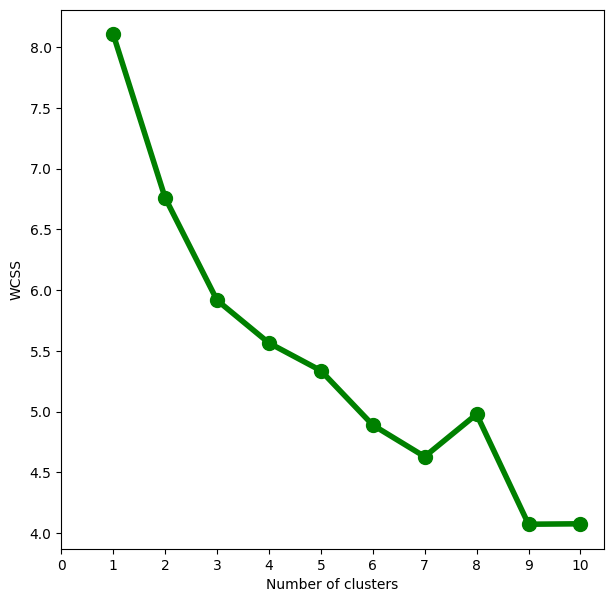

In [30]:
# find the optimal number of clusters using elbow method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

WCSS = []
for i in range(1,11):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(pca_array)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (7,7))
plt.plot(range(1,11),WCSS, linewidth=4, markersize=10,marker='o',color = 'green')
plt.xticks(np.arange(11))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [31]:

Scene = dict(xaxis = dict(title  = '1st dimension -->'),yaxis = dict(title  = '2nd dimension--->'),zaxis = dict(title  = '3rd dimension-->'))

trace = go.Scatter3d(x=tsne_result[:, 0], y=tsne_result[:, 1], z=tsne_result[:, 2], mode='markers',marker=dict(color = [0, 1, 2, 3, 4, 5, 6, 7], size= 10, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()


In [ ]:

pca = PCA(n_components=3)
X = pca.fit_transform(scaled_df)
print(f"PCA transformed dimn: {X.shape}")

fig = px.scatter_3d(X[:number_rows],x=0,y=1,z=2, color=llm_utt_col[:number_rows])
fig.show()

#Reference to PCA can be found here:
# https://www.kdnuggets.com/2023/05/principal-component-analysis-pca-scikitlearn.html

<span style="font-size:28px; color:yellow">Captured Variance</span>

Text(0.5, 1.0, 'Dimensions vs. Captured Variance Ratio')

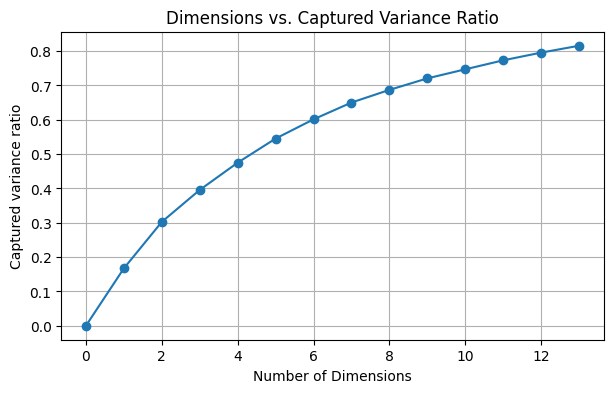

In [30]:
import numpy as np
import matplotlib.pyplot as plt

nums = np.arange(14)

var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(scaled_df)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(7,4),dpi=100)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('Number of Dimensions')
plt.ylabel('Captured variance ratio')
plt.title('Dimensions vs. Captured Variance Ratio')


<span style="font-size:28px; color:yellow">Computing Cosine Similarities</span>

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
import datetime
from typing import List
import datetime
import numpy as np
import pandas as pd
import csv

def embedding(utterance : str):
    embedding = hf.embed_query(utterance)
    return embedding

def pairwise_cosine_similarity(user_utter : str, llm_uttr : str):
    distances = []
    #for i in range(len(user_utter) - 1): #last utterance has nothing to compare with
    embedding_current = embedding(user_utter)
    embedding_next = embedding(llm_uttr)
    
    # Calculate cosine similarity --> values between -1(180 degree opposite) to 1(aligned)
    similarity = cosine_similarity([embedding_current], [embedding_next])[0][0] #extracts the scalar value from the returned 2d array
    
    # Convert to cosine distance
    #distance = 1 - similarity

        # Append cosine distance to the list
        #distances.append(distance)

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return similarity

def calculate_cosine_distances(utterances : List) -> List:
    distances = []
    for i in range(len(utterances) - 1): #last utterance has nothing to compare with
        embedding_current = embedding(utterances[i])
        embedding_next = embedding(utterances[i + 1])
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0] #extracts the scalar value from the returned 2d array
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances

#filename = 'LLM_utt_2024-07-19-13:55:22.csv'
df = pd.read_csv(out_file)
user_utt_col = df['User_utterance']
llm_utt_col = df['LLM_utterance']
#out_file = open(pathname + "Nav_similarity_output" + str(datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")) + ".csv", "w")

number_rows = int(input("Number of rows: ")) 
all_user_uttr = []
all_llm_uttr = []
pairwise_similarity = []
llm_avg_similarities = []

'''for row_index, row in list(enumerate(reader))[2:number_rows + 1]:
    csv_dict[count] = {'user_utt' : row[0],
                        'llm_utt' : row[1]}
    count += 1
    all_user_uttr.append(row[0])
    all_llm_uttr.append(row[1])'''
    
#compares every llm_utt with every other user_utt --> assigns the mean similarity score to that llm_utt
for j, llm in enumerate(llm_utt_col[1:number_rows+1]):
    comparative_similarity = []
    for k, user in enumerate(user_utt_col[1:number_rows+1]):
        comparative_similarity.append(pairwise_cosine_similarity(user, llm))
    #print(f"com_sim: {comparative_similarity}")
    pairwise_similarity.append(comparative_similarity[j])   #extracts and stores the matching index value which is basically a vanilla pairwise similarity
    llm_avg_similarity = np.mean(comparative_similarity)
    llm_avg_similarities.append(llm_avg_similarity)
    all_user_uttr.append(user_utt_col[j])
    all_llm_uttr.append(llm_utt_col[j])
    #print(f"llm_avg_similaritiea: {llm_avg_similarities}")

# Writes into csv    
ds = pd.DataFrame({'User_utterance' : user_utt_col[1:number_rows+1],
                   'LLM_utterance' : llm_utt_col[1:number_rows+1],
                   'Pairwise Similarity' : pairwise_similarity,
                   'Comparative Avg Similarity' : llm_avg_similarities})  
ds.to_csv(str(pathname + 'all_similarities.csv'), index=False) 
#print(user_uttr_dist)


In [31]:
print(all_user_uttr[1:5])

# Embedded distances
'''user_uttr_dist = calculate_cosine_distances(all_user_uttr)
llm_uttr_dist = calculate_cosine_distances(all_llm_uttr)'''

['weather', "What's the weather", "What's the weather today", 'Weather']


'user_uttr_dist = calculate_cosine_distances(all_user_uttr)\nllm_uttr_dist = calculate_cosine_distances(all_llm_uttr)'

<span style="font-size:32px; color:yellow">Plotting the Similarities</span>

Breakpoint Threshold: 0.8271711600148183


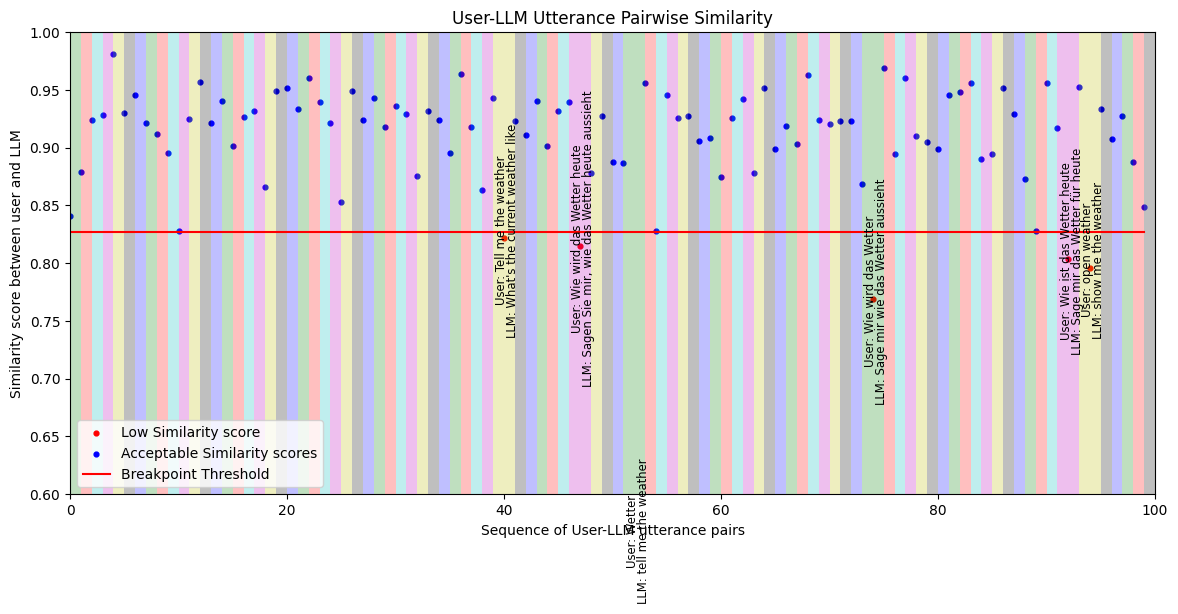

Breakpoint Threshold: 0.6458799096907499


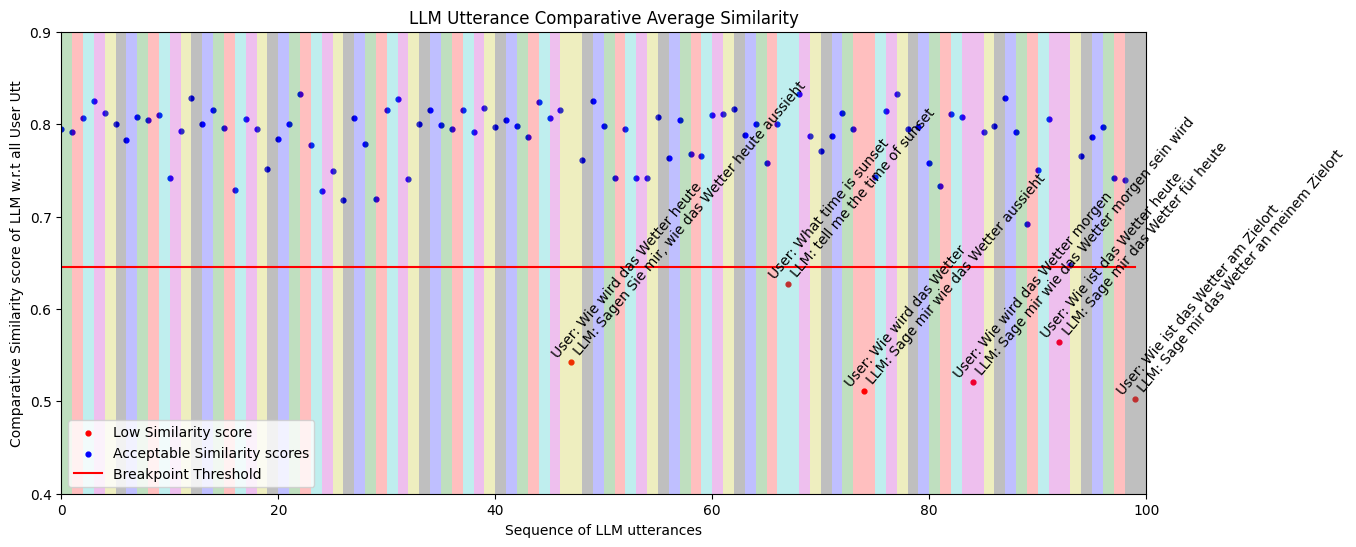

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def dist_plot(distances, user_utt=None, llm_utt=None, schema= None):
    plt.figure(figsize=(14,6), dpi=100)

    X = np.linspace(0,len(distances)-1,num=len(distances))

    if schema == 1:
        y_upper_bound = .5
        y_lower_bound = -4.440892098500626e-16
        plt.plot(distances)

    if schema == 2:
        y_upper_bound = 1
        y_lower_bound = 0.6

    if schema == 3:
        y_upper_bound = 0.9
        y_lower_bound = 0.4

    plt.ylim(y_lower_bound, y_upper_bound)
    plt.xlim(0, len(distances))
    
    # We need to get the distance threshold that we'll consider an outlier
    # We'll use numpy .percentile() for this
    if schema == 1:
        breakpoint_percentile_threshold = 70
        breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # for more chunks, lower the percentile cutoff

    # distance = similarity for schema 2 & 3
    else:
        breakpoint_percentile_threshold = 6
        breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # for more chunks, lower the percentile cutoff
        low_similarity_scores = [d for d in distances if d<breakpoint_distance_threshold]
        low_similarity_indices = [idx for idx, d in enumerate(distances) if d<breakpoint_distance_threshold]
        acceptable_scores = [d for d in distances if d>= breakpoint_distance_threshold]
        acceptable_indices = [idx for idx, d in enumerate(distances) if d>= breakpoint_distance_threshold]
        plt.scatter(low_similarity_indices, low_similarity_scores, color='r', s=12, label='Low Similarity score')
        plt.scatter(acceptable_indices, acceptable_scores, color='b', s=12, label='Acceptable Similarity scores')
        for i, itm in enumerate(low_similarity_indices):   
            if schema == 2:
                plt.text(itm-0.79, low_similarity_scores[i]+0.0065, f'User: {user_utt[itm]}', rotation=90, verticalalignment='center', size='small', color='black')
                plt.text(itm+0.22, low_similarity_scores[i]+0.0065, f'LLM: {llm_utt[itm]}', rotation=90, verticalalignment='center', size='small', color='black')

            if schema == 3:
                plt.text(itm-1.95, low_similarity_scores[i]+0.0025, f'User: {user_utt[itm]}', rotation=50, horizontalalignment='left', verticalalignment='bottom', size='medium', color='black')
                plt.text(itm+0.03, low_similarity_scores[i]+0.0054, f'LLM: {llm_utt[itm]}', rotation=50, horizontalalignment='left', verticalalignment='bottom', size='medium', color='black')


    #plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-')
    Y = np.full(len(distances), breakpoint_distance_threshold)
    plt.plot(X, Y, color='r', label='Breakpoint Threshold')
    print(f"Breakpoint Threshold: {breakpoint_distance_threshold}")

    # How many distances are actually above this one
    num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above the threshold
    #plt.text(x=(len(distances)*.01), y=y_upper_bound/60, s=f"{num_distances_above_theshold + 1} Chunks")  #prints total splitted chunks

    # To get the index of the distances that are above the threshold.  where to split the utterance
    indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

    # Start of the shading and text
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, breakpoint_index in enumerate(indices_above_thresh):
        start_index = 0 if i == 0 else indices_above_thresh[i - 1]
        end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

        plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
        plt.text(x=np.average([start_index, end_index]),
                y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                s=f"", horizontalalignment='center',
                rotation='vertical')

    # # Additional step to shade from the last breakpoint to the end of the dataset
    if indices_above_thresh:
        last_breakpoint = indices_above_thresh[-1]
        if last_breakpoint < len(distances):
            plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
            plt.text(x=np.average([last_breakpoint, len(distances)]),
                    y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                    s=f"",
                    rotation='vertical')
            
    if schema == 1: #distance schema
        plt.title("Utterance Chunks splitted as per their divergences")
        plt.xlabel("Sequence of Utterances")
        plt.ylabel("Cosine distance between sequential utterances")
        plt.legend()
        plt.show()
    if schema == 2:   #pairwise similarity schema
        plt.title("User-LLM Utterance Pairwise Similarity")
        plt.xlabel("Sequence of User-LLM utterance pairs")
        plt.ylabel("Similarity score between user and LLM")
        plt.legend(loc='lower left')
        plt.show()
    if schema == 3:   #comp_avg similarity schema
        plt.title("LLM Utterance Comparative Average Similarity")
        plt.xlabel("Sequence of LLM utterances")
        plt.ylabel("Comparative Similarity score of LLM w.r.t all User Utt")
        plt.legend(loc='lower left')
        plt.show()

pathname = '/home/devbox/test/Diversifying_uttr/data/Inq_weather/'
read =  pd.read_csv(str(pathname + 'all_similarities.csv'))     
#read = pd.read_csv('/home/devbox/test/Diversifying_uttr/data/Nav_unique/Nav_all_similarities.csv')
#read2 = pd.read_csv('/home/devbox/test/Diversifying_uttr/data/Nav_unique/Nav_all_similarities.csv')

comp_avg_similarities = read['Comparative Avg Similarity']
pairwise_sim = read['Pairwise Similarity']
user_utterances = read['User_utterance']
llm_utterances = read['LLM_utterance']
dist_plot(pairwise_sim, user_utterances, llm_utterances, 2)
dist_plot(comp_avg_similarities, user_utterances, llm_utterances, 3)
#dist_plot(user_uttr_dist, 1)
#dist_plot(llm_uttr_dist, 1)


#print(user_uttr_dist[:6])
#print(llm_uttr_dist[:6])
#print(user_llm_similarity[:6])